In [4]:
import pandas as pd
import seaborn as sns
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import folium
plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', None)

In [5]:
# Initialize the map centered around Spain
m = folium.Map(location=[40.4168, -3.7038], zoom_start=6)  # Centered around Madrid's coordinates

# Add markers for each city
cities = {
    "Madrid": [40.4168, -3.7038],
    "Barcelona": [41.3851, 2.1734],
    "Seville": [37.3886, -5.9823],
    "Bilbao": [43.2630, -2.9350],
    "Valencia": [39.4699, -0.3763]
}

for city, coords in cities.items():
    folium.Marker(coords, tooltip=city).add_to(m)

# Display the map
m

# Data Importing and Cleaning

## Energy Dataset

In [6]:
# Reading data
energy_df = pd.read_csv('data/energy_dataset.csv', index_col='time')

# Converting index to datetime format
energy_df.index = pd.to_datetime(energy_df.index, utc=True, infer_datetime_format=True)

In [7]:
energy_df.head()

,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation marine,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,NaN,863.0,1051.0,1899.0,0.0,7096.0,43.0,73.0,49.0,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
2015-01-01 00:00:00+00:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,NaN,920.0,1009.0,1658.0,0.0,7096.0,43.0,71.0,50.0,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2015-01-01 01:00:00+00:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,NaN,1164.0,973.0,1371.0,0.0,7099.0,43.0,73.0,50.0,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
2015-01-01 02:00:00+00:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,NaN,1503.0,949.0,779.0,0.0,7098.0,43.0,75.0,50.0,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
2015-01-01 03:00:00+00:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,NaN,1826.0,953.0,720.0,0.0,7097.0,43.0,74.0,42.0,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


Dropping any columns with all zero/NaN values, as well as columns which include forecasting data. We want to make our own forecasts. This returns a dataset with only relevant columns.

In [8]:
# Select columns where the max is not equal to 0 or NaN
column_max = energy_df.max()
columns_to_keep = column_max[(column_max != 0) & (~column_max.isna())].index
energy_df = energy_df[columns_to_keep]

# dropping forecast columns
forecast_cols = [col for col in energy_df.columns if 'forecast' in col]
energy_df = energy_df.drop(columns=forecast_cols)

In [9]:
energy_df.describe().round(2)

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load actual,price day ahead,price actual
count,35045.00,35046.00,35046.00,35046.00,35045.00,35045.00,35045.00,35046.00,35047.00,35046.00,35046.00,35046.00,35045.00,35046.00,35028.00,35064.00,35064.00
mean,383.51,448.06,5622.74,4256.07,298.32,475.58,972.12,2605.11,6263.91,60.23,85.64,1432.67,269.45,5464.48,28696.94,49.87,57.88
std,85.35,354.57,2201.83,1961.60,52.52,792.41,400.78,1835.20,839.67,20.24,14.08,1680.12,50.20,3213.69,4574.99,14.62,14.20
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,18041.00,2.06,9.33
25%,333.00,0.00,4126.00,2527.00,263.00,0.00,637.00,1077.25,5760.00,53.00,73.00,71.00,240.00,2933.00,24807.75,41.49,49.35
50%,367.00,509.00,4969.00,4474.00,300.00,68.00,906.00,2164.00,6566.00,57.00,88.00,616.00,279.00,4849.00,28901.00,50.52,58.02
75%,433.00,757.00,6429.00,5838.75,330.00,616.00,1250.00,3757.00,7025.00,80.00,97.00,2578.00,310.00,7398.00,32192.00,60.53,68.01
max,592.00,999.00,20034.00,8359.00,449.00,4523.00,2000.00,9728.00,7117.00,106.00,119.00,5792.00,357.00,17436.00,41015.00,101.99,116.80


In [10]:
energy_df.isnull().sum()

generation biomass                             19
generation fossil brown coal/lignite           18
generation fossil gas                          18
generation fossil hard coal                    18
generation fossil oil                          19
generation hydro pumped storage consumption    19
generation hydro run-of-river and poundage     19
generation hydro water reservoir               18
generation nuclear                             17
generation other                               18
generation other renewable                     18
generation solar                               18
generation waste                               19
generation wind onshore                        18
total load actual                              36
price day ahead                                 0
price actual                                    0
dtype: int64

In [11]:
# Interpolating null values
energy_df.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

# Verifying that null values are no longer present
energy_df.isnull().sum(axis=0).sum() == 0

True

In [14]:
def plot_time_series(df, cols=None, title="Time Series", ylabel="Values", 
                     subplots=False, start=0, end=None, legend=True):
    """
    Plots a time series using pandas DataFrame's plot method with seaborn styles.

    Parameters:
    - df (pandas.DataFrame): DataFrame containing the time series data.
    - cols (list): List of columns from df to plot. If None, all columns are plotted.
    - title (str): Title for the plot.
    - ylabel (str): Y-axis label.
    - subplots (bool): If True, plots each column in a separate subplot. Otherwise, plots them on the same axes.
    - start (int): Starting index for slicing the df. Useful for zooming in on a part of the time series.
    - end (int): Ending index for slicing the df. Useful for zooming in on a part of the time series.
    - legend (bool): If True, displays the legend.

    Returns:
    None. Displays the plot.
    """

    # Set seaborn styling for the plot
    sns.set()

    # Plot the specified columns of the DataFrame from start to end index.
    df[cols][start:end].plot(
        subplots=subplots, 
        figsize=(15,5)
    )

    # Set title and axis labels for the plot
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel(ylabel)

    # Display the legend if legend=True
    if legend:
        plt.legend()

    # Display the plot
    plt.show()

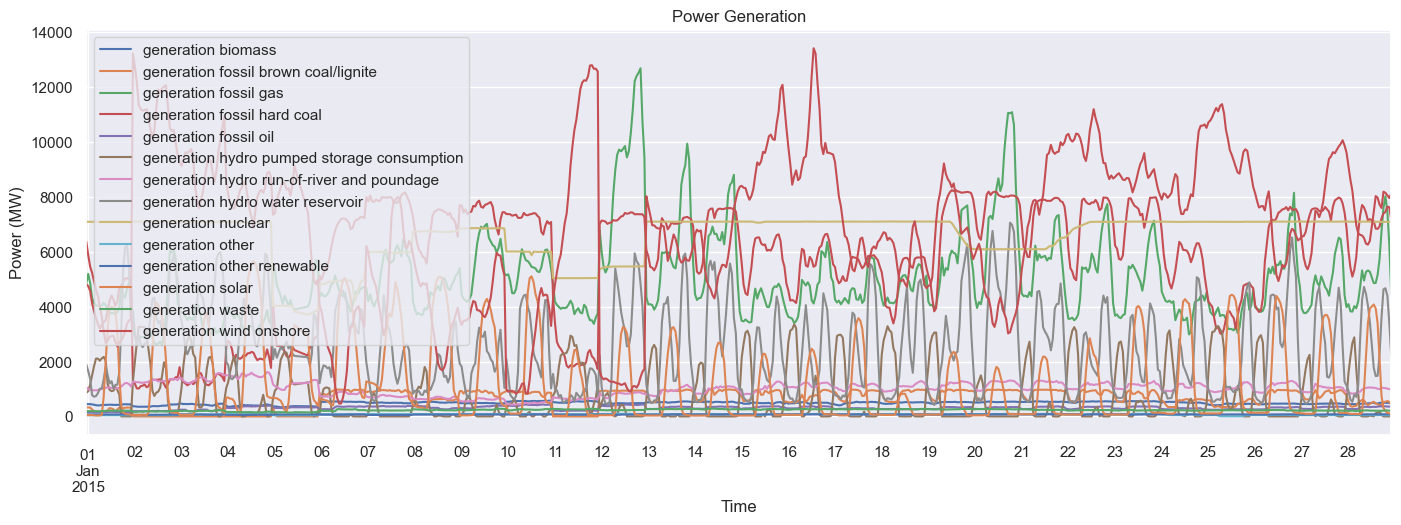

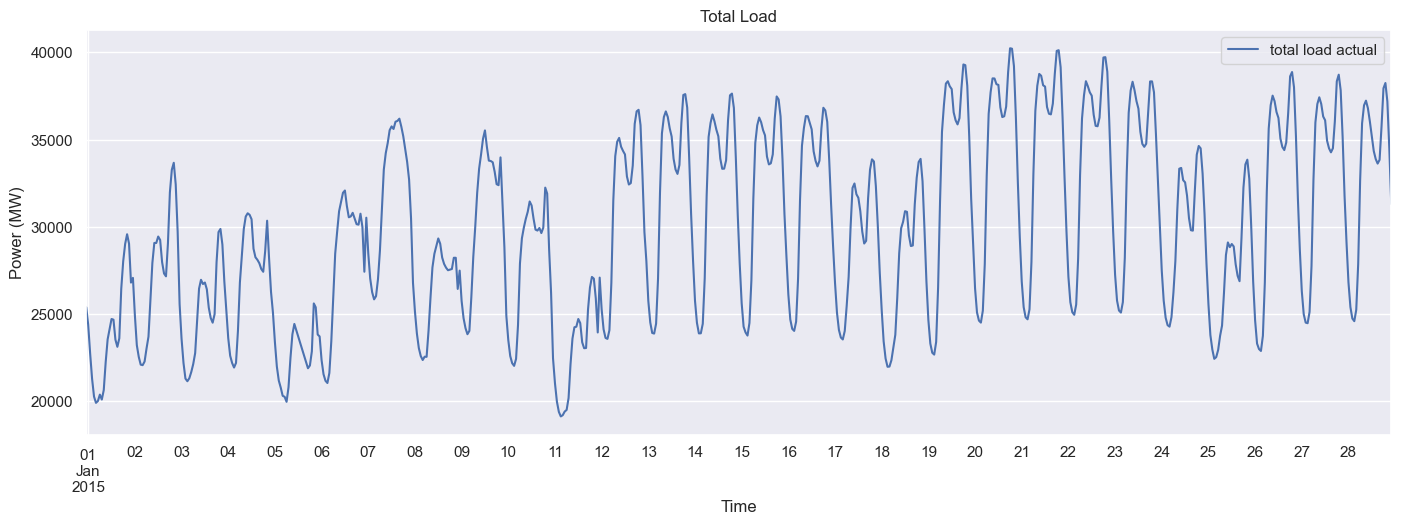

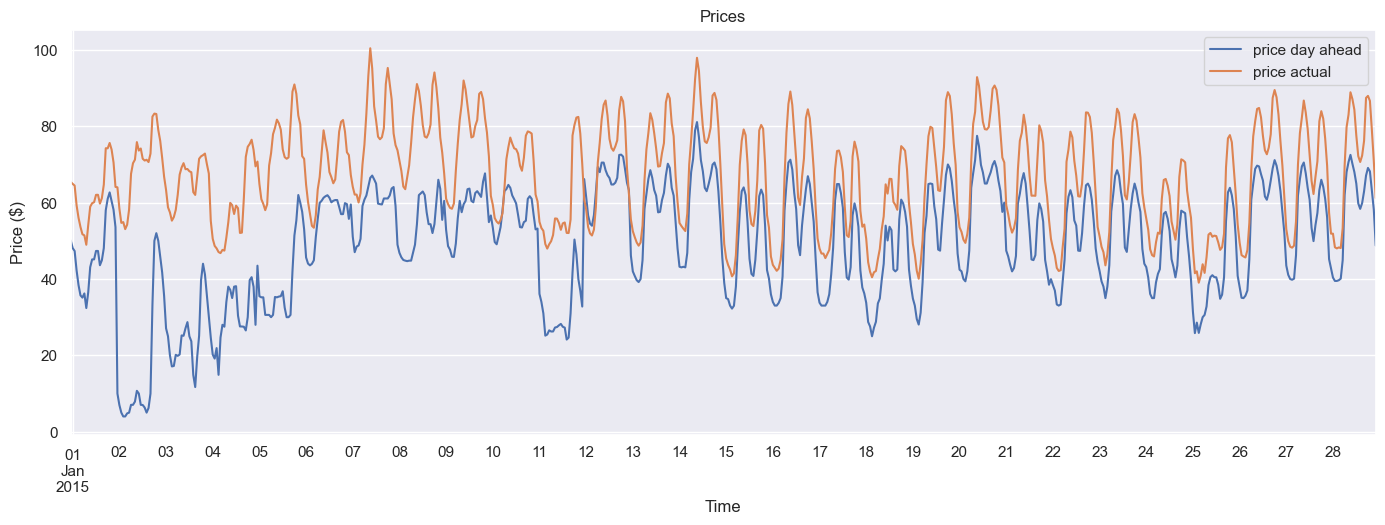

In [34]:
end = 4*7*24
plot_time_series(energy_df, cols = energy_df.columns[0:14], title='Power Generation', ylabel="Power (MW)", end=end)
plot_time_series(energy_df, cols = energy_df.columns[14], title='Total Load', ylabel="Power (MW)", end=end)
plot_time_series(energy_df, cols = energy_df.columns[15:17], title='Prices', ylabel="Price ($)", end=end)

## Weather Dataset

In [35]:
# Uploading weather dataset
weather_df = pd.read_csv('data/weather_features.csv', index_col= 'dt_iso')

# Correctly formatting the index column
weather_df.index = pd.to_datetime(weather_df.index, utc=True, infer_datetime_format=True)

In [36]:
weather_df.head()

,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
dt_iso,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2015-01-01 00:00:00+00:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2015-01-01 01:00:00+00:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2015-01-01 02:00:00+00:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2015-01-01 03:00:00+00:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n


In [37]:
weather_df.describe().round(2)

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
count,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00
mean,289.62,288.33,291.09,1069.26,68.42,2.47,166.59,0.08,0.00,0.00,25.07,759.83
std,8.03,7.96,8.61,5969.63,21.90,2.10,116.61,0.40,0.01,0.22,30.77,108.73
min,262.24,262.24,262.24,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,200.00
25%,283.67,282.48,284.65,1013.00,53.00,1.00,55.00,0.00,0.00,0.00,0.00,800.00
50%,289.15,288.15,290.15,1018.00,72.00,2.00,177.00,0.00,0.00,0.00,20.00,800.00
75%,295.15,293.73,297.15,1022.00,87.00,4.00,270.00,0.00,0.00,0.00,40.00,801.00
max,315.60,315.15,321.15,1008371.00,100.00,133.00,360.00,12.00,2.32,21.50,100.00,804.00


From the dataframe description, a number of things stand out. These are listed below:

* The ***rain_3h*** column doesn't make sense. The rain_1h and rain_3h columns specificy the amount of rainfall which occured in the previous 1 and 3 hours, respectively. The rain_3h column is erronous because it has a lower mean value than the rain_1h column. If it were correct, it would be larger. For this reason, we will drop the column. We now check for null values in the dataset.

* Some columns have extremely high standard deviations. Examining the ***pressure*** collumn especially, we find a massive standard deviation. We should examine the outliers of all columns in more detail.

* The maximum value in the ***wind_speed*** column, we find the maximum value to be very high. Becuase wind speeds are measured in m/s, the maximum value of 133 m/s equates to ~480 km/h. This is faster than any recorded wind speed on earth, and should thus be further examined.

To mitigate these concerns we start by dropping the ***rain_3h*** column.

In [39]:
# Dropping rain_3h column
weather_df.drop('rain_3h', axis=1);

In [210]:
# Checking for null values
weather_df.isnull().sum()

city_name              0
temp                   0
temp_min               0
temp_max               0
pressure               0
humidity               0
wind_speed             0
wind_deg               0
rain_1h                0
rain_3h                0
snow_3h                0
clouds_all             0
weather_id             0
weather_main           0
weather_description    0
weather_icon           0
dtype: int64

To examine outliers, we first drop catagorical columns and normalize the numerical columns such that they can all be inspected on a boxplot with the same axis.

In [40]:
# Dropping non catagorical columns
drop_cols = ['weather_id', 'weather_main', 'weather_description', 'weather_icon', 'city_name']
weather_df_nums = weather_df.drop(drop_cols, axis = 1)

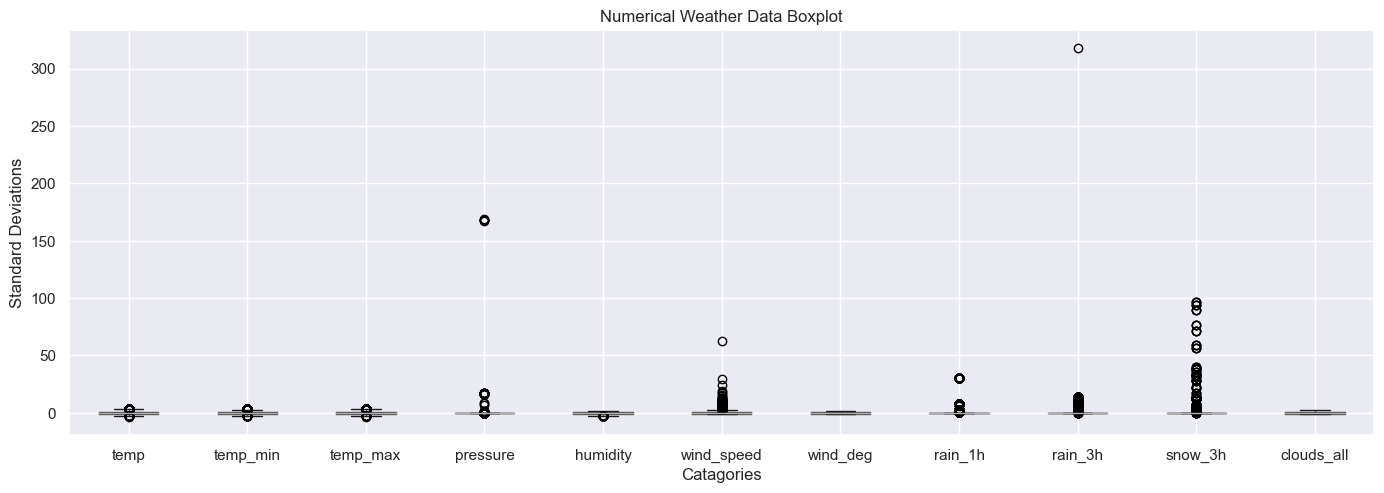

In [41]:
# Normalizing columns
normalized_df = (weather_df_nums - weather_df_nums.mean()) / weather_df_nums.std()

# Creating and labelling boxplot
normalized_df.boxplot(figsize = (15,5))
plt.title('Numerical Weather Data Boxplot')
plt.ylabel('Standard Deviations')
plt.xlabel('Catagories')
plt.show()

<Axes: xlabel='pressure'>

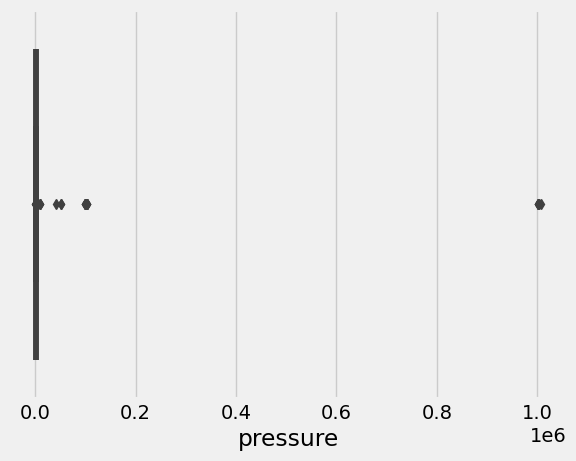

In [193]:
sns.boxplot(x = weather_df['pressure'])

In [197]:
weather_df.loc[weather_df.pressure >= 1050, 'pressure'] = np.nan
weather_df.loc[weather_df.pressure <= 950, 'pressure'] = np.nan

<Axes: xlabel='pressure'>

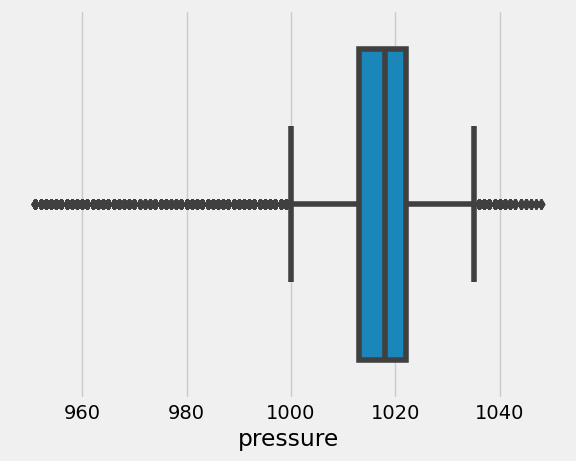

In [198]:
sns.boxplot(x = weather_df['pressure'])

<Axes: xlabel='wind_speed'>

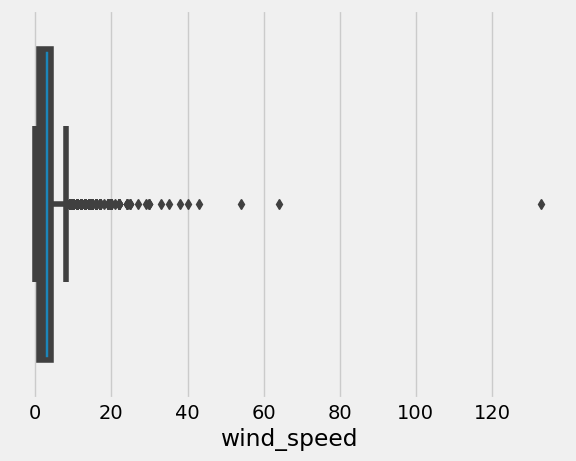

In [199]:
sns.boxplot(x = weather_df['wind_speed'])

<Axes: xlabel='wind_speed'>

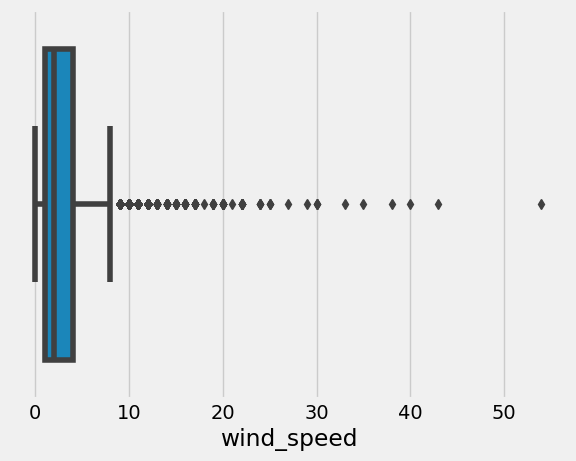

In [204]:
weather_df.loc[weather_df['wind_speed'] >= 60, 'wind_speed'] = np.nan
sns.boxplot(x=weather_df.wind_speed)

In [44]:
def percentage_error(df, actual, target, new_column_name):
    actual, target = np.array(df[actual]), np.array(df[target])
    df[new_column_name] = np.abs((actual - target) / actual) * 100
    return df